In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook
# from Iterative_solvers_l0_l1 import *
import scipy.io as sio
import itertools
from operator import itemgetter, attrgetter
import matplotlib.pyplot as plt
from sklearn.linear_model import lars_path, enet_path, lasso_path
from itertools import cycle

import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression

import seaborn as sns
c = sns.color_palette("Blues",20)
print("DDD")

Populating the interactive namespace from numpy and matplotlib
DDD


# Data pre-processing and derivative computation

In [69]:
print(" reading data .... ")


center_box = sio.loadmat('./dso/task/pde/data/domain_profile.mat')
center_box_coordinates  = sio.loadmat('./dso/task/pde/data/domain_coordinates.mat')
center_UF   = center_box['center_U']
center_VF   = center_box['center_V']
center_vorF = center_box['center_vor']
center_x   = center_box_coordinates['center_x']
center_y   = center_box_coordinates['center_y']

max_time   = 500

center_U   = center_UF[:,:,0:max_time]
center_V   = center_VF[:,:,0:max_time]
center_vor = center_vorF[:,:,0:max_time]

dx = center_x[0,1] - center_x[0,0]
dy = center_y[1,0] - center_y[0,0]
print(" dx is ", dx , " dy is ", dy)

nx = center_x.shape[1]
ny = center_x.shape[0]

print(" nx is ", nx, " ny is ", ny)
print(" shape of shape of center_U ", center_U.shape)


noise_level  = 0.0
alphas_size  = 20
np.random.seed(0)
center_Un = center_U + noise_level*np.std(center_U)*np.random.randn(center_U.shape[0],center_U.shape[1],max_time)
center_Vn = center_V + noise_level*np.std(center_V)*np.random.randn(center_U.shape[0],center_U.shape[1],max_time)
center_vorn = center_vor + 0.02*noise_level*np.std(center_vor)*np.random.randn(center_U.shape[0],center_U.shape[1],max_time)


print(" variance of u ", np.std(center_U))
print(" variance of v ", np.std(center_V))
print(" variance of vor ", 0.02*np.std(center_vor))

print(" net noise addition to U  ", noise_level*np.std(center_U))
print(" net noise addition to V  ", noise_level*np.std(center_V))
print(" net noise addition to Un ", 0.02*noise_level*np.std(center_vor))

# FUn = center_Un.reshape(center_U.shape[0]**2,max_time)
# FVn = center_Vn.reshape(center_U.shape[0]**2,max_time)
# FVorn = center_vorn.reshape(center_U.shape[0]**2,max_time)

# uun,usn,uvn = np.linalg.svd(FUn, full_matrices = False)
# vun,vsn,vvn = np.linalg.svd(FVn, full_matrices = False)
# vorun,vorsn,vorvn = np.linalg.svd(FVorn, full_matrices = False)

# print(" shape of usn ", usn.shape)
# print(" shape of vsn ", vsn.shape)

# dim = 20
# center_Un = (uun[:,:dim].dot(np.diag(usn[:dim]).dot(uvn[:dim,:]))).reshape(center_U.shape[0],center_U.shape[1],max_time)
# center_Vn = (vun[:,:dim].dot(np.diag(vsn[:dim]).dot(vvn[:dim,:]))).reshape(center_U.shape[0],center_U.shape[1],max_time)
# center_vorn = (vorun[:,:dim].dot(np.diag(vorsn[:dim]).dot(vorvn[:dim,:]))).reshape(center_U.shape[0],center_U.shape[1],max_time)

# print(" number of modes included ", dim)



num_xy = 121*53  #500
num_t = 499 #(150-50) #40
num_points = num_xy*num_t
points = {}

u = np.zeros((num_points,1))
v = np.zeros((num_points,1))

vor    = np.zeros((num_points,1))
vor_t  = np.zeros((num_points,1))
vor_x  = np.zeros((num_points,1))
vor_y  = np.zeros((num_points,1))
vor_xx = np.zeros((num_points,1))
vor_yy = np.zeros((num_points,1))


dt = 0.0005
print(" dx ", dx , " dy ", dy)
print(" dt ", dt)
print(" num_points ", num_points)

np.random.seed(0) #20
count = 0
space_count = 0
space_points = {}
# for p in range(num_xy):
y_list= np.arange(2,123)
x_list = np.arange(70,123)
for y in y_list:
    for x in x_list:
        space_points[space_count] = [x,y]
        space_count = space_count + 1
        for t in range(num_t):
            points[count] = [x,y,t]
            count = count + 1

counter = 0
for p in points.keys():
    [x,y,time] = points[p]
    
    u[p]    = center_Un[x,y, time]
 
    
    v[p]    = center_Vn[x,y, time]

    
    vor[p]     = center_vorn[x,y, time]
    vor_t[p]   = (center_vorn[x,y, time+1] - center_vorn[x,y,time])/(dt)
    vor_y[p]   = (center_vorn[x+1,y,time] - center_vorn[x-1,y,time])/(2.0*dx)
    vor_x[p]   = (center_vorn[x,y+1,time] - center_vorn[x,y-1,time])/(2.0*dy)
    vor_yy[p]  = (center_vorn[x+1,y,time] - 2.0*center_vorn[x,y,time] + center_vorn[x-1,y,time])/(dx*dx)
    vor_xx[p]  = (center_vorn[x,y+1,time] - 2.0*center_vorn[x,y,time] + center_vorn[x,y-1,time])/(dy*dy)

    
    if(counter%1000 == 0):
        print(" completed count ", counter)
    counter = counter + 1

 reading data .... 
 dx is  0.00793651  dy is  0.00793651
 nx is  127  ny is  127
 shape of shape of center_U  (127, 127, 500)
 variance of u  0.35583139267551606
 variance of v  0.16273770401827878
 variance of vor  0.27874105394999626
 net noise addition to U   0.0
 net noise addition to V   0.0
 net noise addition to Un  0.0
 dx  0.00793651  dy  0.00793651
 dt  0.0005
 num_points  3200087
 completed count  0
 completed count  1000
 completed count  2000
 completed count  3000
 completed count  4000
 completed count  5000
 completed count  6000
 completed count  7000
 completed count  8000
 completed count  9000
 completed count  10000
 completed count  11000
 completed count  12000
 completed count  13000
 completed count  14000
 completed count  15000
 completed count  16000
 completed count  17000
 completed count  18000
 completed count  19000
 completed count  20000
 completed count  21000
 completed count  22000
 completed count  23000
 completed count  24000
 completed count  

In [70]:
X_data = np.hstack([u,v])
#X_ders = np.hstack([np.ones((num_points,1)), ux, uy, uxx, uxy, uyy, vx, vy, vxx, vxy, vyy])
X_ders = np.hstack([np.ones((num_points,1)), u*vor_x,\
    v*vor_y, vor_xx, vor_yy])

In [84]:
vor.reshape(121,53,499).transpose(1,0,2)[:,:,10]

array([[ 8.42530e-01,  3.36752e-01,  9.39763e-02, ...,  2.15628e-03,
         1.77425e-02,  9.42862e-02],
       [ 8.68369e-01,  3.47019e-01,  9.68305e-02, ...,  2.22190e-03,
         1.82825e-02,  9.71602e-02],
       [ 8.95098e-01,  3.57638e-01,  9.97819e-02, ...,  2.28978e-03,
         1.88412e-02,  1.00133e-01],
       ...,
       [ 1.16080e+01,  3.44578e+00, -4.53557e-02, ..., -1.71392e+00,
        -1.54391e+00, -4.15139e-01],
       [ 1.14019e+01,  5.24169e-01, -4.06391e+00, ..., -7.21448e+00,
        -7.21177e+00, -6.02057e+00],
       [ 5.80483e+00, -9.85150e+00, -1.63667e+01, ..., -2.20536e+01,
        -2.25762e+01, -2.16903e+01]])

In [83]:
vvy = vor_y
vvy.reshape(121,53,499).transpose(1,0,2)[:,:,10]

array([[ 3.20241517e+00,  1.27259967e+00,  3.53807908e-01, ...,
         8.13329789e-03,  6.69311826e-02,  3.56220807e-01],
       [ 3.31178314e+00,  1.31581766e+00,  3.65752705e-01, ...,
         8.41049781e-03,  6.92180820e-02,  3.68348304e-01],
       [ 3.42688411e+00,  1.36117765e+00,  3.78346402e-01, ...,
         8.70218774e-03,  7.16183814e-02,  3.81137301e-01],
       ...,
       [ 6.80336823e+01, -2.00802431e+02, -3.08156356e+02, ...,
        -4.37467476e+02, -4.49151882e+02, -4.35736174e+02],
       [-3.65599615e+02, -8.37728422e+02, -1.02824442e+03, ...,
        -1.28139951e+03, -1.32503393e+03, -1.34033479e+03],
       [-1.54613930e+03, -2.26043746e+03, -2.51350342e+03, ...,
        -2.75011434e+03, -2.85603055e+03, -2.96163112e+03]])

In [76]:
center_vorn[:,:,10][70:123, 2:123]

array([[ 8.42530e-01,  3.36752e-01,  9.39763e-02, ...,  2.15628e-03,
         1.77425e-02,  9.42862e-02],
       [ 8.68369e-01,  3.47019e-01,  9.68305e-02, ...,  2.22190e-03,
         1.82825e-02,  9.71602e-02],
       [ 8.95098e-01,  3.57638e-01,  9.97819e-02, ...,  2.28978e-03,
         1.88412e-02,  1.00133e-01],
       ...,
       [ 1.16080e+01,  3.44578e+00, -4.53557e-02, ..., -1.71392e+00,
        -1.54391e+00, -4.15139e-01],
       [ 1.14019e+01,  5.24169e-01, -4.06391e+00, ..., -7.21448e+00,
        -7.21177e+00, -6.02057e+00],
       [ 5.80483e+00, -9.85150e+00, -1.63667e+01, ..., -2.20536e+01,
        -2.25762e+01, -2.16903e+01]])

In [79]:
vor_t.reshape(121,53,499).transpose(1,0,2)[:,:,10]
# center_vorn[:,:,10]
# (center_vorn[:,:,1]-center_vorn[:,:,0])/dt


array([[ 1.040160e+02,  1.043840e+02,  6.603740e+01, ...,  5.398060e+00,
         2.422660e+01,  6.635360e+01],
       [ 1.073040e+02,  1.076200e+02,  6.805700e+01, ...,  5.562600e+00,
         2.496680e+01,  6.839360e+01],
       [ 1.107100e+02,  1.109680e+02,  7.014420e+01, ...,  5.732820e+00,
         2.573240e+01,  7.050400e+01],
       ...,
       [ 1.522000e+03,  7.506800e+02, -2.247346e+02, ..., -1.644580e+03,
        -1.409440e+03, -6.523920e+02],
       [ 1.059400e+03, -3.004720e+02, -1.722660e+03, ..., -3.957760e+03,
        -3.778580e+03, -2.877380e+03],
       [ 3.468200e+02, -1.586400e+03, -3.417800e+03, ..., -6.150000e+03,
        -6.096600e+03, -5.161000e+03]])

In [71]:
# X_ders.shape
vor_t.shape
np.linalg.lstsq(X_ders, vor_t)[0]

c:\Users\lthpc\Anaconda3\envs\dso\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[ 0.00785776],
       [-0.9991315 ],
       [-1.00139023],
       [ 0.0249965 ],
       [ 0.02500091]])

(127, 127, 500)


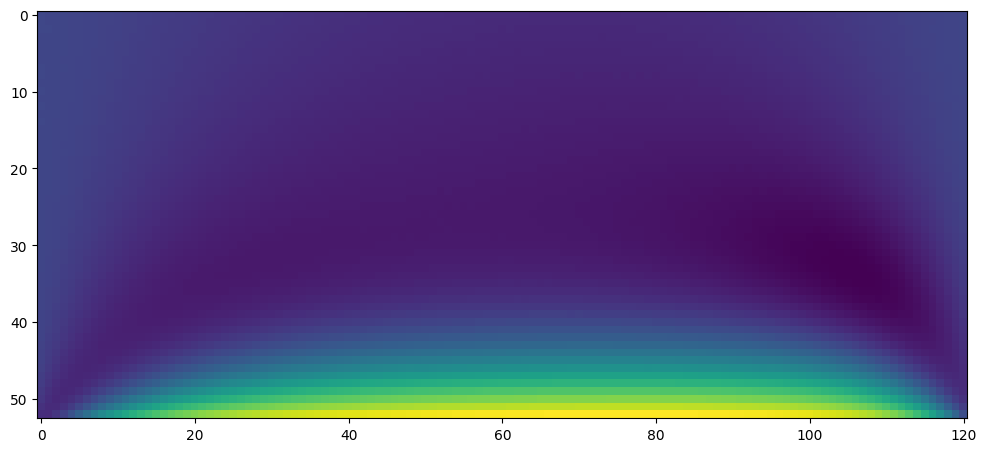

In [33]:
print(center_Un.shape)
plt.imshow(center_Un[70:123,2:123,300])
plt.show()

In [35]:
center_y

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00793651, 0.00793651, 0.00793651, ..., 0.00793651, 0.00793651,
        0.00793651],
       [0.015873  , 0.015873  , 0.015873  , ..., 0.015873  , 0.015873  ,
        0.015873  ],
       ...,
       [0.984127  , 0.984127  , 0.984127  , ..., 0.984127  , 0.984127  ,
        0.984127  ],
       [0.992063  , 0.992063  , 0.992063  , ..., 0.992063  , 0.992063  ,
        0.992063  ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

In [34]:
center_x

array([[0.        , 0.00793651, 0.015873  , ..., 0.984127  , 0.992063  ,
        1.        ],
       [0.        , 0.00793651, 0.015873  , ..., 0.984127  , 0.992063  ,
        1.        ],
       [0.        , 0.00793651, 0.015873  , ..., 0.984127  , 0.992063  ,
        1.        ],
       ...,
       [0.        , 0.00793651, 0.015873  , ..., 0.984127  , 0.992063  ,
        1.        ],
       [0.        , 0.00793651, 0.015873  , ..., 0.984127  , 0.992063  ,
        1.        ],
       [0.        , 0.00793651, 0.015873  , ..., 0.984127  , 0.992063  ,
        1.        ]])

# Dictionary construction

In [ ]:
# Form a huge matrix using up to quadratic polynomials in all variables.
X_data = np.hstack([u,v])
#X_ders = np.hstack([np.ones((num_points,1)), ux, uy, uxx, uxy, uyy, vx, vy, vxx, vxy, vyy])
X_ders = np.hstack([np.ones((num_points,1)), ux, uy, uxx, uxy, uyy, vx, vy, vxx, vxy, vyy, 
                    u, v, vor, u*vor_x, u*vor_y, v*vor_x, v*vor_y, vor_xx, vor_yy])

desc_store_u = ['u','u^2','u^3']
desc_store_v = ['v','v^2','v^3']
ders_store_u = np.hstack([u,u**2,u**3])
ders_store_v = np.hstack([v,v**2,v**3])
print(" shape of ders_store_u ", ders_store_u.shape)
print(" shape of ders_store_v ", ders_store_v.shape)
print(" shape of u ", u.shape[0])
print(" shape of v ", v.shape[0])

for iterate in range(0, 3):
    U_desc = ['' for i in range(iterate+1)]
    V_desc = ['' for i in range(iterate+1)]
    U_ders = np.zeros((u.shape[0],iterate+1))
    V_ders = np.zeros((v.shape[0],iterate+1))
    for sparsity in range(0, iterate+1):
        U_ders[:,sparsity] = ders_store_u[:,sparsity]
        V_ders[:,sparsity] = ders_store_v[:,sparsity]
        U_desc[sparsity]   = desc_store_u[sparsity]
        V_desc[sparsity]   = desc_store_v[sparsity]
        
    w_ders = np.hstack([np.ones((num_points,1)), vor, vor**2, vor_x, vor_y, vor_xx, vor_yy])
    w_desc = ['','w', 'w^2', 'w_{x}', 'w_{y}', 'w_{xx}', 'w_{yy}',]
    
    uw_mixed = np.zeros((U_ders.shape[0], U_ders.shape[1]*w_ders.shape[1]))
    description_uw = ['' for i in range(len(w_desc)*len(U_desc))]
    for i in range(0, len(w_desc)):
        for j in range(0, len(U_desc)):
            description_uw[j+i*len(U_desc)] = U_desc[j] + w_desc[i]
            uw_mixed[:,j+i*len(U_desc)] = U_ders[:,j]*w_ders[:,i]
        
    vw_mixed = np.zeros((V_ders.shape[0], V_ders.shape[1]*w_ders.shape[1]))
    description_vw = ['' for i in range(len(w_desc)*len(V_desc))]
    for i in range(0, len(w_desc)):
        for j in range(0, len(V_desc)):
            description_vw[j+i*len(V_desc)] = V_desc[j] + w_desc[i]
            vw_mixed[:,j+i*len(V_desc)] = V_ders[:,j]*w_ders[:,i]
        
    X = np.hstack([w_ders, uw_mixed, vw_mixed])
    description = w_desc + description_uw + description_vw
    print(" done with iteration ", iterate)
    for i in range(0, len(description)):
        print(i, description[i])
    
description_trunc, X_no_intercept = remove_intercept(X, description) # changed from X to Rn
u_t = vor_t

 shape of ders_store_u  (100000, 3)
 shape of ders_store_v  (100000, 3)
 shape of u  100000
 shape of v  100000
 done with iteration  0
0 
1 w
2 w^2
3 w_{x}
4 w_{y}
5 w_{xx}
6 w_{yy}
7 u
8 uw
9 uw^2
10 uw_{x}
11 uw_{y}
12 uw_{xx}
13 uw_{yy}
14 v
15 vw
16 vw^2
17 vw_{x}
18 vw_{y}
19 vw_{xx}
20 vw_{yy}
 done with iteration  1
0 
1 w
2 w^2
3 w_{x}
4 w_{y}
5 w_{xx}
6 w_{yy}
7 u
8 u^2
9 uw
10 u^2w
11 uw^2
12 u^2w^2
13 uw_{x}
14 u^2w_{x}
15 uw_{y}
16 u^2w_{y}
17 uw_{xx}
18 u^2w_{xx}
19 uw_{yy}
20 u^2w_{yy}
21 v
22 v^2
23 vw
24 v^2w
25 vw^2
26 v^2w^2
27 vw_{x}
28 v^2w_{x}
29 vw_{y}
30 v^2w_{y}
31 vw_{xx}
32 v^2w_{xx}
33 vw_{yy}
34 v^2w_{yy}
 done with iteration  2
0 
1 w
2 w^2
3 w_{x}
4 w_{y}
5 w_{xx}
6 w_{yy}
7 u
8 u^2
9 u^3
10 uw
11 u^2w
12 u^3w
13 uw^2
14 u^2w^2
15 u^3w^2
16 uw_{x}
17 u^2w_{x}
18 u^3w_{x}
19 uw_{y}
20 u^2w_{y}
21 u^3w_{y}
22 uw_{xx}
23 u^2w_{xx}
24 u^3w_{xx}
25 uw_{yy}
26 u^2w_{yy}
27 u^3w_{yy}
28 v
29 v^2
30 v^3
31 vw
32 v^2w
33 v^3w
34 vw^2
35 v^2w^2
36 v^3w^2
37 vw_{x}


# Stability selection

In [ ]:
B = 50; reduced_size = 1000; rescale = 1.0; M = 15; max_iter = 10000; sub_iter = 1000

print(" X_no_intercept shape ", X_no_intercept.shape, " u_t shape ", u_t.shape)

subsample_info_lasso, subsample_info_iht_d, \
            subsample_info_STR, alphas_sample = stability_selection(X_no_intercept, u_t, reduced_size, M, B, rescale, max_iter, sub_iter)
    
print(" done with stability selection ")
print(" done \n ")


 X_no_intercept shape  (100000, 48)  u_t shape  (100000, 1)


/lustre/projects/jupyterhub/maddukon/Data_driven/Stability_selection_results /pde-stride/Iterative_solvers_l0_l1.py:419: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if lam != 0: coeff[0,biginds] = np.linalg.lstsq(X[:, biginds].T.dot(X[:, biginds]) + lam*np.eye(len(biginds)),X[:, biginds].T.dot(y))[0].reshape(len(biginds),)


 done with sample  0  size  1000
 done with sample  5  size  1000
 done with sample  10  size  1000
 done with sample  15  size  1000
 done with sample  20  size  1000
 done with sample  25  size  1000
 done with sample  30  size  1000
 done with sample  35  size  1000
 done with sample  40  size  1000
 done with sample  45  size  1000
 done with stability selection 
 done 
 


# Results

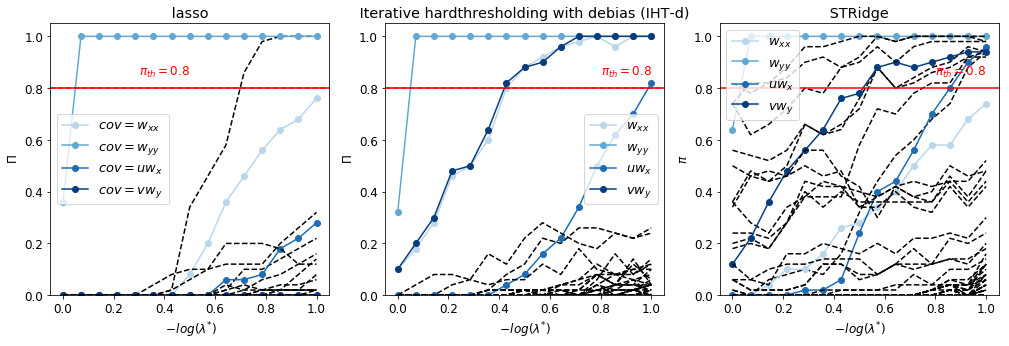

In [ ]:
covar_1 = 4
covar_2 = 5
covar_3 = 15
covar_4 = 39

# rescaling lambdas
n_samples = subsample_info_lasso.shape[0]; 
p = subsample_info_lasso.shape[1];
normalized_alphas_sample = np.zeros((n_samples, M))
for sample in range(0, n_samples):
    normalized_alphas_sample[sample,:] = alphas_sample[sample,:]/alphas_sample[sample,0]
neg_log_stable_lambda = -np.log10(normalized_alphas_sample[0,:])

importance_plot = np.zeros((p, M))
for alpha in range(0, M):
    for i in range(0, p):
        for sample in range(0, n_samples):
            if(subsample_info_lasso[sample, i, alpha] != 0):
                importance_plot[i,alpha] = importance_plot[i,alpha] + 1

        importance_plot[i,alpha] = importance_plot[i,alpha]/n_samples
        
plt.axhline(y=0.8, color='r', linestyle='--')

plt.subplot(1,3,1)
for i in range(0, p):
    if(i == covar_1 ):
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '-o',color=c[5],label='$cov = %s$' %description_trunc[i])
    elif(i == covar_2):
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '-o', color=c[10],label='$cov = %s$' %description_trunc[i])
    elif(i == covar_3):
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '-o',color=c[15],label='$ cov = %s$' %description_trunc[i])
    elif(i == covar_4):
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '-o',color=c[19],label='$ cov = %s$' %description_trunc[i])
    else:
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '--', color='black')
        
plt.rcParams.update({'font.size': 12})
plt.title(" lasso ")
plt.xlabel(" $ -log(\lambda^{*}) $ ")
plt.ylabel(" $ \Pi $")
plt.ylim(0, 1.05)  
plt.legend(loc='best', prop={'size':13})
plt.text(0.3, 0.85,'$\pi_{th}=0.8$',color='red')
plt.axhline(y=0.8, color='r', linestyle='-')

importance_plot = np.zeros((p, M))
for alpha in range(0, M):
    for i in range(0, p):
        for sample in range(0, n_samples):
            if(subsample_info_iht_d[sample, i, alpha] != 0):
                importance_plot[i,alpha] = importance_plot[i,alpha] + 1

        importance_plot[i,alpha] = importance_plot[i,alpha]/n_samples
        
plt.axhline(y=0.8, color='r', linestyle='--')
        
plt.subplot(1,3,2)
for i in range(0, p):
    if(i == covar_1 ):
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '-o',color=c[5],label='$%s$' %description_trunc[i])
    elif(i == covar_2):
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '-o', color=c[10],label='$%s$' %description_trunc[i])
    elif(i == covar_3):
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '-o',color=c[15],label='$%s$' %description_trunc[i])
    elif(i == covar_4):
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '-o',color=c[19],label='$%s$' %description_trunc[i])
    else:
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '--', color='black')
        
plt.rcParams.update({'font.size': 12})
plt.title(" Iterative hardthresholding with debias (IHT-d) ")
plt.xlabel(" $ -log(\lambda^{*}) $ ")
plt.ylabel(" $ \Pi $")
plt.ylim(0, 1.05)  
plt.legend(loc='best', prop={'size':13})
plt.text(0.8, 0.85,'$\pi_{th}=0.8$',color='red')
plt.axhline(y=0.8, color='r', linestyle='-')
        
importance_plot = np.zeros((p, M))
for alpha in range(0, M):
    for i in range(0, p):
        for sample in range(0, n_samples):
            if(subsample_info_STR[sample, i, alpha] != 0):
                importance_plot[i,alpha] = importance_plot[i,alpha] + 1

        importance_plot[i,alpha] = importance_plot[i,alpha]/n_samples
        
plt.axhline(y=0.8, color='r', linestyle='--')
        
plt.subplot(1,3,3)
for i in range(0, p):
    if(i == covar_1 ):
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '-o',color=c[5],label='$%s$' %description_trunc[i])
    elif(i == covar_2):
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '-o', color=c[10],label='$%s$' %description_trunc[i])
    elif(i == covar_3):
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '-o',color=c[15],label='$%s$' %description_trunc[i])
    elif(i == covar_4):
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '-o',color=c[19],label='$%s$' %description_trunc[i])
    else:
        plt.plot(neg_log_stable_lambda, importance_plot[i,:], '--', color='black')
        
plt.rcParams.update({'font.size': 12})
plt.title(" STRidge ")
plt.xlabel(" $ -log(\lambda^{*}) $ ")
plt.ylabel(" $ \pi $")
plt.ylim(0, 1.05)  
plt.text(0.8, 0.85,'$\pi_{th}=0.8$', color='red')
plt.legend(loc='best', prop={'size':13})
plt.axhline(y=0.8, color='r', linestyle='-')
plt.gcf().set_size_inches(17,5)